In [ ]:
# ensure that the imported .py file will get auto imported and updated whenever there is a change
%load_ext autoreload
%autoreload 2

In [ ]:
''' 

# # global_attention_mask will be prepared in the same segments
# global_attention_mask = torch.zeros_like(input_ids)
# # set global_attention_mask on first token or only the top layer first token?
# according to https://github.com/huggingface/transformers/issues/18190, As you are running summarization, it is LEDForConditionalGeneration. For this model, we should put 1 for the global_attention_mask on the first token <s> in the encoder input sequence.
https://discuss.huggingface.co/t/flan-t5-t5-what-is-the-difference-between-automodelforseq2seqlm-and-t5forconditionalgeneration/29225/5
'''

In [ ]:
!pip install transformers
# !pip install datasets
!pip install rouge_score
# !pip install sentencepiece
!pip install rouge

In [32]:

import os, json, logging
# from nltk.tokenize import word_tokenize #Used to extract words from documents
# from nltk.stem import WordNetLemmatizer #Used to lemmatize words
# from nltk.corpus import stopwords
import pandas as pd
import tqdm as notebook_tqdm
# import textwrap
from datetime import datetime
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
transformers_logger = logging.getLogger("transformers")
logging.getLogger("transformers").setLevel(logging.ERROR)
from transformers import LEDForConditionalGeneration, LEDTokenizer
from datasets import load_dataset, load_metric
import torch
from rouge import Rouge
from rouge_score import rouge_scorer
import datasets
from datasets import Dataset, DatasetDict

pd.options.display.max_colwidth = 1000


c:\Users\Claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:

max_input_length = 8192
max_output_length = 512
batch_size = 2

project_path = os.getcwd()
project_data_path = project_path + "/data"
project_processed_data_path = project_path + "/processed"
if not os.path.exists(project_data_path):
    os.makedirs(project_data_path)
if not os.path.exists(project_processed_data_path):
    os.makedirs(project_processed_data_path)

In [ ]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

In [ ]:
def load_data(file_path):
    with open(file_path, 'r', encoding = "utf-8") as file:
        data = json.load(file)
    return data
      
# FConvert JSON dictionary structure to a plain dataset with only two columns - Text, and Groundtruth
def convert_dict_to_dataset(section, result):
    content = section.get("Text")
    ground_truth = section.get("Groundtruth")
    result.append({"Text": content, "Groundtruth": ground_truth})
    
    if "Subsections" in section and len(section['Subsections']) > 0:
        for subsection in section["Subsections"]:
            convert_dict_to_dataset(subsection, result)
    return result 

def convert_json_to_csv_wrapper(json_file_full_name, converted_file_full_name):
    if not os.path.exists(json_file_full_name):
        print("the json file does not exist.")
        return

    record_list = load_data(json_file_full_name)
    result = []
    for item in record_list:
        convert_dict_to_dataset(item, result)

    data = pd.DataFrame(result)
    data.to_csv(converted_file_full_name, index=False)
    print("converted to csv file - {}".format(converted_file_full_name))
    display(data.head())

convert_json_to_csv_wrapper(project_path + "/dataset/dataset_ground_truth.json", project_path + "/dataset/training.csv")
convert_json_to_csv_wrapper(project_path + "/dataset/dataset_eval_ground_truth.json", project_path + "/dataset/eval.csv")
convert_json_to_csv_wrapper(project_path + "/dataset/dataset_test_ground_truth.json", project_path + "/dataset/test.csv")
    

In [ ]:
train_df = pd.read_csv(project_path + "/dataset/training.csv")
train_df.dropna(inplace=True)
val_df = pd.read_csv(project_path + "/dataset/eval.csv")
val_df.dropna(inplace=True)
display(train_df.head())
display(val_df.head())

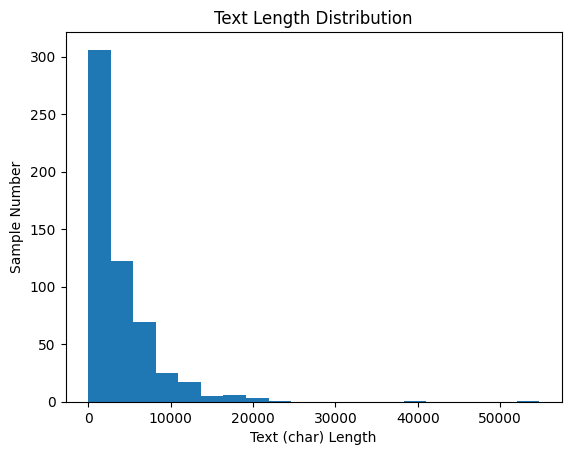

In [40]:
text_len = train_df['Text'].str.len()
plt.hist(text_len, bins = 20)
plt.title("Text Length Distribution")
plt.xlabel("Text (char) Length")
plt.ylabel("Sample Number")
plt.show()

In [34]:
# print(train_dataset.shape, val_dataset.shape)
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [35]:
train_dataset = train_dataset.select(range(100))
val_dataset = val_dataset.select(range(10))

In [ ]:

#Define the sequence length for the model.
# seq_length=1024
max_input_length = 8192
max_output_length = 512
batch_size = 2


#Define the Model
class Model_operation:  
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

    def __init__(self, model_name):
        self.model_name = model_name
        self.tokenizer = LEDTokenizer.from_pretrained(model_name)
        self.model = LEDForConditionalGeneration.from_pretrained(model_name).to(DEVICE)
        self.config = LEDForConditionalGeneration.from_pretrained(model_name).config
        print("config:", self.config)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-5, weight_decay=0.01)
        self.criterion = torch.nn.CrossEntropyLoss()        

    # tokenize the data
    def process_data_to_model_inputs(self, batch):
        inputs = self.tokenizer(
            batch['Text'],
            padding="max_length",
            truncation=True,
            max_length=max_input_length,
        )
        outputs = self.tokenizer(
            batch['Groundtruth'],
            padding="max_length",
            truncation=True,
            max_length=max_output_length,
        )

        batch["input_ids"] = inputs.input_ids
        batch["attention_mask"] = inputs.attention_mask

        print("input_ids shape:", len(batch["input_ids"]), len(batch["input_ids"][0]))

        # create 0 global_attention_mask lists
        batch["global_attention_mask"] = len(batch["input_ids"]) * [
            [0 for _ in range(len(batch["input_ids"][0]))]
        ]
      # according to https://github.com/huggingface/transformers/issues/18190, As you are running summarization, it is LEDForConditionalGeneration. For this model, we should put 1 for the global_attention_mask on the first token <s> in the encoder input sequence.
        batch["global_attention_mask"][:, 0] = 1
        batch["labels"] = outputs.input_ids
        # We have to make sure that the PAD token is ignored by setting it to -100
        batch["labels"] = [
            [-100 if token == self.tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]
        return batch

    
    # Function to train model
    def train_and_validate_model(self, train_ds, validate_ds):
      total_loss = 0.0  # Initialize total loss
      self.model.train()



        # get the input_ids, tokenized content text, label text
        # self.tokenize_sections(data, results)
        # added by me
        # print("data from train_loading:", data, len(results), results)
        # for result in results:
          ids = data["input_ids"]
          am = data["attention_mask"]
          gam = data['global_attention_mask']
          labels = data["labels"]
          output = self.model(input_ids = ids, attention_mask = am, labels = labels, global_attention_mask = gam, use_cache = False)

          # need to check how to express this
          loss = output.loss
          logits = outputs.logits
          logits_flat = logits.view(-1, logits.size(-1))
          labels_flat = labels.view(-1)

        # Backward pass
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
          total_loss += loss.item()
      return total_loss
    

    # Function to calculate ROUGE scores for generated summary and ground truth
    def calculate_rouge_scores(self, generated_summary, ground_truth_summary): 
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        scores = scorer.score(generated_summary, ground_truth_summary)
        rouge1_f1 = scores['rouge1'].fmeasure
        rouge2_f1 = scores['rouge2'].fmeasure
        rougeL_f1 = scores['rougeL'].fmeasure
        return rouge1_f1, rouge2_f1, rougeL_f1
    
    # Function to evaluate model using val set
    def validate_model(self, val_loader):
        val_loss=0.0
        total_rouge1_f1 = 0.0
        total_rouge2_f1 = 0.0
        total_rougeL_f1 = 0.0
        num_samples = 0
      
      # model. eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode. torch. no_grad() impacts the autograd engine and deactivate it.
      self.model.eval()
      with torch.no_grad():
        for val_data in val_loader:
          val_results = []
          self.tokenize_sections(val_data, val_results)
          for val_result in val_results:
            input_ids = val_result["input_ids"]
            attention_mask = val_result["attention_mask"]
            labels = val_result["labels"]
            loss,logits = self.forward(input_ids, attention_mask, labels)
            val_loss +=loss.item()      

            # Decode the predicted summary
            predicted_token_probs = torch.softmax(logits[0], dim=-1)
            predicted_summary_ids = torch.argmax(predicted_token_probs, dim=-1).tolist()
            predicted_summary = tokenizer.decode(predicted_summary_ids, skip_special_tokens=True)
            ground_truth_summary = tokenizer.decode(labels[0], skip_special_tokens=True) 

            # Calculate ROUGE scores
            rouge1_f1, rouge2_f1, rougeL_f1 = model_summarizer.calculate_rouge_scores(predicted_summary, ground_truth_summary)

            # Accumulate ROUGE scores   
            total_rouge1_f1 += rouge1_f1
            total_rouge2_f1 += rouge2_f1
            total_rougeL_f1 += rougeL_f1
            num_samples += 1

        return val_loss,total_rouge1_f1,total_rouge2_f1,total_rougeL_f1,num_samples
    
    #Function to test the model using test dataset
    def test_model(self,section, model):
        
      section_summary_results = {}
      content = section["Text"]
      section_name = section["Section"]
      ground_truth_summary = section.get("Groundtruth")[0]
      if content and ground_truth_summary:
        # Tokenize the content

        inputs = self.tokenizer(content, return_tensors="pt", max_length=seq_length, truncation=True)
        labels = self.tokenizer(ground_truth_summary, return_tensors="pt", max_length=seq_length, truncation=True)["input_ids"]

        input_ids = inputs["input_ids"].to(self.DEVICE)
        attention_mask = inputs["attention_mask"].to(self.DEVICE)
        labels = labels.to(self.DEVICE)

        # model. eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode. torch. no_grad() impacts the autograd engine and deactivate it.
        model_summarizer.model.eval()

        with torch.no_grad():
          outputs = self.model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)

          logits = outputs.logits
          # Apply softmax to convert logits to probabilities
          probs = torch.softmax(logits[0], dim=-1)          
          generated_ids = torch.argmax(probs, dim=-1)

          # Decode the generated summary using the tokenizer
          summary_text = self.tokenizer.decode(generated_ids, skip_special_tokens=True)
          ground_truth_summary = tokenizer.decode(labels[0], skip_special_tokens=True)

            # Calculate ROUGE scores
          rouge1_f1, rouge2_f1, rougeL_f1 = model_summarizer.calculate_rouge_scores(summary_text, ground_truth_summary)

        section_summary_results["Section Name"] = section_name
        section_summary_results["Generated Summary"] = summary_text
        section_summary_results["ROUGE-1 F1"] = rouge1_f1
        section_summary_results["ROUGE-2 F1"] = rouge2_f1
        section_summary_results["ROUGE-L F1"] = rougeL_f1
        
        print("Section Name: ", section_name)
        wrapped_output = textwrap.fill(str(summary_text), width=80)
        print("Generated Summary: ", wrapped_output)

        if "Subsections" in section:
          for subsection in section["Subsections"]:
            model_summarizer.test_model(subsection,model)

      return section_summary_results

    
    
    def log_metrics(self,epoch, train_loss, val_loss, rouge_scores):
      log_file = "logs/metrics_log.txt"
      with open(log_file, "a") as f:        
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        log_str = f"{timestamp}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, ROUGE: {rouge_scores}\n"
        f.write(log_str)
        


#Model Inference
#Generate Summary for the content using the loaded model
    def generate_summary(self,content):
        max_length=300
        num_beams=4
        inputs = self.tokenizer(content, return_tensors="pt", max_length=1024, truncation=True)
        summary_ids = self.model.generate(inputs.input_ids.to(DEVICE), max_length=max_length, num_beams=num_beams, early_stopping=True)
        summary_text = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary_text

#Parse each sections and subsection to generate summaries from the model
    def process_section(self,section,results,modelsummarizer): 
        # Process the content of the each section
        section_summary_results = {}
        content = section["Text"]
        section_name=section["Section"]
        summary_text = model_summarizer.generate_summary(modelsummarizer,content)
        section_summary_results["Section Name"] = section_name
        section_summary_results["Generated Summary"] = summary_text
        results.append(section_summary_results)
        print("Section Name: ", section_name)
        wrapped_output = textwrap.fill(str(summary_text), width=80)
        print("Generated Summary: ", wrapped_output)
        # Process the subsections if they exist
        if "Subsections" in section:
            for subsection in section["Subsections"]:
                model_summarizer.process_section(subsection,results,modelsummarizer)
            
    # Summarize the section contents and subsection contents
    def summarize_pdf(pdf_data, output_file,modelsummarizer):
        all_results = []
        for section in pdf_data:
            model_summarizer.process_section(section,all_results,modelsummarizer)
        
        with open(output_file, "w") as json_file:
            json.dump(all_results, json_file, indent=4)    
        
    
# model_name = "allenai/led-large-16384-arxiv"
# model_summarizer = SummarizationModel(model_name)
# model = model_summarizer.model
# tokenizer = model_summarizer.tokenizer    




In [ ]:
from transformers import LEDForConditionalGeneration, LEDTokenizer
import torch

# pretrained_model_name = "allenai/led-large-16384-arxiv"

model_action = Model_operation()
train_dataset = train_dataset.map(
    model_action.process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size)

val_dataset = val_dataset.map(
    model_action.process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size)

# tokenizer = LEDTokenizer.from_pretrained(pretrained_model_name)
# model = LEDForConditionalGeneration.from_pretrained(pretrained_model_name, return_dict_in_generate=True, gradient_checkpointing=True, use_cache=False)
# model.state_dict()
# config = LEDForConditionalGeneration.from_pretrained(pretrained_model_name).config
# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=0.01)
# criterion = torch.nn.CrossEntropyLoss()  


In [ ]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

In [ ]:
# set generate hyperparameters
model_action.config.num_beams = 2
model_action.config.max_length = 512
model_action.config.min_length = 100
model_action.config.length_penalty = 2.0
model_action.config.early_stopping = True
model_action.config.no_repeat_ngram_size = 3

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    


In [ ]:
# json_dict = load_data(project_path + "/dataset/dataset_ground_truth.json")
# train_data = pd.read_csv(project_processed_data_path + '/1901.00936v3.csv')
train_data = pd.read_csv(project_path + "/dataset/test.csv")
train_data 

In [ ]:


# refer to this post for the model training
# https://huggingface.co/allenai/led-large-16384-arxiv
# https://colab.research.google.com/drive/12INTTR6n64TzS4RrXZxMSXfrOd9Xzamo?usp=sharing
# the above two examples are both about generating (inference)
# This page is the entry point for this model !!! https://huggingface.co/docs/transformers/en/model_doc/led
#the LEDTokenizer is just a alias of BertTokenizer: https://huggingface.co/docs/transformers/v4.18.0/en/model_doc/bart#transformers.BartTokenizer
# check this post "a notebook showing how to fine tune LED" from page https://huggingface.co/docs/transformers/en/model_doc/led
# about dataset and dataloader and using dataset.map method https://www.scaler.com/topics/pytorch/map-style-vs-itetrable-datasets/

# def training_one_section(text, ground_truth):
#     if text and ground_truth:
#         # since it is long text, it might be separated into multiple input_ids, that is, multiple sequences
      #   input_ids = tokenizer(text, return_tensors="pt", max_length=max_input_length).input_ids
      #   # global_attention_mask will be prepared in the same segments
      #   global_attention_mask = torch.zeros_like(input_ids)
      #   # set global_attention_mask on first token
      #   global_attention_mask[:, 0] = 1

      #   label = tokenizer(ground_truth, return_tensors="pt", max_length=seq_length, truncation=True)["input_ids"]
        
      #   print("starting training:", len(input_ids), global_attention_mask.shape)
      #   outputs = model(input_ids=input_ids,
      #                       attention_mask=global_attention_mask,
      #                       labels=label)
      #   logits = outputs.logits
      #   logits_flat = logits.view(-1, logits.size(-1))
      #   labels_flat = label.view(-1)
      #   loss = criterion(logits_flat, labels_flat)
          
      # return loss,logits


In [ ]:
def process_data_to_model_inputs(text, ground_truth):
    # tokenize the inputs and labels
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
    )
    outputs = tokenizer(
        ground_truth,
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
    )

    input_ids = inputs.input_ids
    print("input_ids shape:", len(input_ids), len(input_ids[0]))
    attention_mask = inputs.attention_mask

    # create 0 global_attention_mask lists
    global_attention_mask = len(input_ids) * [
        [0 for _ in range(len(input_ids[0]))]
    ]

    # # global_attention_mask will be prepared in the same segments
    # global_attention_mask = torch.zeros_like(input_ids)
    # # set global_attention_mask on first token
    # global_attention_mask[:, 0] = 1
    

    # since above lists are references, the following line changes the 0 index for all samples
    global_attention_mask[0][0] = 1
    labels = outputs.input_ids

    # We have to make sure that the PAD token is ignored by setting it to -100
    labels = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in labels
    ]

    return input_ids, global_attention_mask, labels

In [ ]:
def train_one_sample(model, input_ids, global_attention_mask, labels):
        outputs = model(input_ids=input_ids,
                            attention_mask=global_attention_mask,
                            labels=labels)
        logits = outputs.logits
        logits_flat = logits.view(-1, logits.size(-1))
        labels_flat = labels.view(-1)
        loss = criterion(logits_flat, labels_flat)

In [ ]:


# Load training data
# train_data = load_data(train_file_path)

In [ ]:
input_ids = tokenizer(LONG_ARTICLE, return_tensors="pt").input_ids
global_attention_mask = torch.zeros_like(input_ids)
# set global_attention_mask on first token
global_attention_mask[:, 0] = 1   

sequences = model.generate(input_ids, global_attention_mask=global_attention_mask).sequences

summary = tokenizer.batch_decode(sequences)